# Support Vector Regressor

Performing support vector regressor modeling on red and white wine data.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Ignore warnings for final notebook output.
import warnings, os
warnings.simplefilter('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [3]:
red_wine = pd.read_csv('./data/winequality-red.csv', sep = ';')
white_wine = pd.read_csv('./data/winequality-white.csv', sep = ';')

In [4]:
def extract_X_and_Y(df, target):
    X = df.drop(target, axis=1)
    Y = df[target]
    return X, Y

In [5]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

# Function to plot the confusion matrix between true and predicted values
# and also prints and returns the precision of each label
def confusion_matrix_and_class_precision(Y_true, Y_pred, labels, title, color):
    class_precision = precision_score(Y_true, Y_pred, average=None, zero_division=0.0)
    cm = confusion_matrix(Y_true, Y_pred)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=color, xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()
    
    print(class_precision)
    return class_precision

## Red Wine Dataset

In [6]:
from sklearn.model_selection import train_test_split

red_train, red_test = train_test_split(red_wine, test_size=0.2, random_state=42, stratify=red_wine['quality'])

red_X_train, red_Y_train = extract_X_and_Y(red_train, 'quality')
red_X_test, red_Y_test = extract_X_and_Y(red_test, 'quality')

Through testing, we've determined that the RBF/Gaussian kernel is the optimal kernel to use for SVR on the wine data, so we only tune hyperparameters for the RBF kernel. Additionally, we apply RobustScaler to deal with the skewed distribution of our predictors, as it is less sensitive to outliers and often suitable for SVM tasks.

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

svrr_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', SVR())
])

svrr_param_grid = {
    'svm__kernel': ['rbf'],
    'svm__C': [0.01, 0.1, 1.0, 10.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__epsilon': [0.01, 0.05, 0.1]
}

svrr_grid = GridSearchCV(svrr_pipeline, svrr_param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
svrr_grid.fit(red_X_train, red_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('svm', SVR())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.01, 0.1, 1.0, 10.0],
                         'svm__epsilon': [0.01, 0.05, 0.1],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['rbf']},
             scoring='neg_mean_squared_error')

In [8]:
svrr_grid.best_params_

{'svm__C': 1.0,
 'svm__epsilon': 0.01,
 'svm__gamma': 'auto',
 'svm__kernel': 'rbf'}

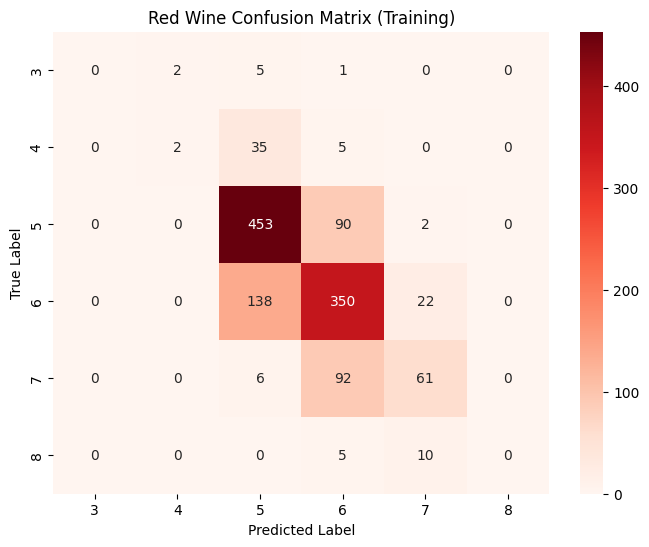

[0.         0.5        0.711146   0.64456722 0.64210526 0.        ]


In [9]:
red_labels = range(3,9)
red_train_pred = np.rint(svrr_grid.predict(red_X_train))

red_train_class_precision = confusion_matrix_and_class_precision(red_Y_train,
                                                                 red_train_pred,
                                                                 red_labels,
                                                                 "Red Wine Confusion Matrix (Training)",
                                                                 "Reds")

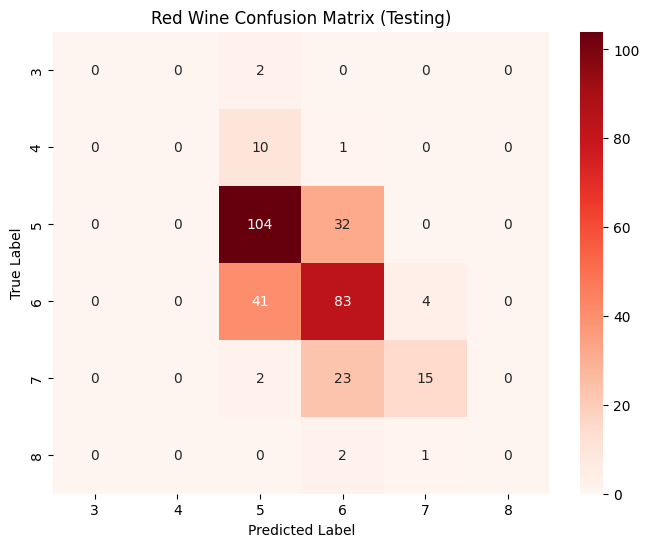

[0.         0.         0.65408805 0.58865248 0.75       0.        ]


In [10]:
red_test_pred = np.rint(svrr_grid.predict(red_X_test))

red_test_class_precision = confusion_matrix_and_class_precision(red_Y_test,
                                                                red_test_pred,
                                                                red_labels,
                                                                "Red Wine Confusion Matrix (Testing)",
                                                                "Reds")

In [12]:
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(red_Y_test, red_test_pred))

Accuracy: 0.63125


**Feature Selection**

In [13]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import LinearSVR

svrr_fs_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('sfs', SequentialFeatureSelector(LinearSVR(),
                                      n_features_to_select=1,
                                      direction='forward',
                                      scoring='neg_mean_squared_error')),
    ('svm', SVR())
])

svrr_fs_param_grid = {
    'sfs__n_features_to_select': np.arange(3, 11),
    'svm__kernel': ['rbf'],
    'svm__C': [0.01, 0.1, 1.0, 10.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__epsilon': [0.01, 0.05, 0.1]
}

svrr_fs_grid = GridSearchCV(svrr_fs_pipeline, svrr_fs_param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
svrr_fs_grid.fit(red_X_train, red_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('sfs',
                                        SequentialFeatureSelector(estimator=LinearSVR(),
                                                                  n_features_to_select=1,
                                                                  scoring='neg_mean_squared_error')),
                                       ('svm', SVR())]),
             n_jobs=-1,
             param_grid={'sfs__n_features_to_select': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                         'svm__C': [0.01, 0.1, 1.0, 10.0],
                         'svm__epsilon': [0.01, 0.05, 0.1],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['rbf']},
             scoring='neg_mean_squared_error')

In [15]:
svrr_fs_grid.best_params_

{'sfs__n_features_to_select': np.int64(9),
 'svm__C': 1.0,
 'svm__epsilon': 0.1,
 'svm__gamma': 'scale',
 'svm__kernel': 'rbf'}

Features selected:

In [16]:
red_X_train.columns[svrr_fs_grid.best_estimator_['sfs'].get_support()]

Index(['volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide',
       'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype='object')

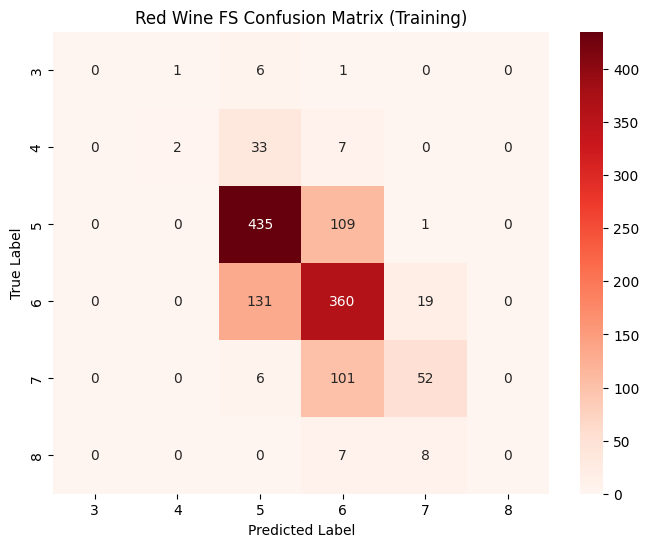

[0.         0.66666667 0.71194763 0.61538462 0.65       0.        ]


In [17]:
red_sfs_train_pred = np.rint(svrr_fs_grid.predict(red_X_train))

red_sfs_train_class_precision = confusion_matrix_and_class_precision(red_Y_train,
                                                                     red_sfs_train_pred,
                                                                     red_labels,
                                                                     "Red Wine FS Confusion Matrix (Training)",
                                                                     "Reds")

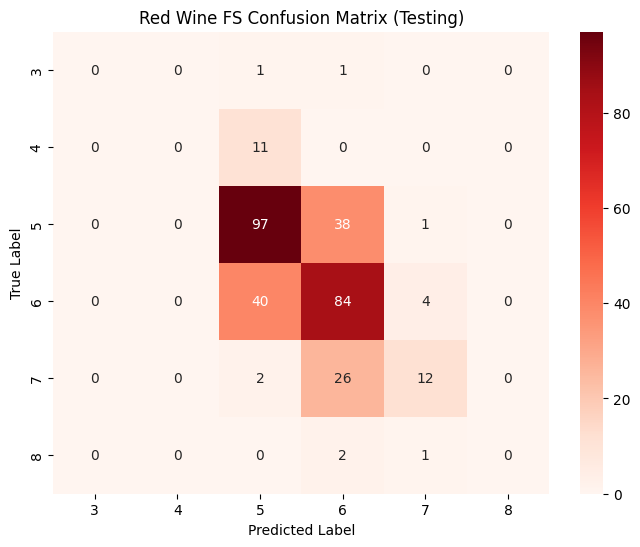

[0.         0.         0.64238411 0.55629139 0.66666667 0.        ]


In [18]:
red_sfs_test_pred = np.rint(svrr_fs_grid.predict(red_X_test))

red_sfs_test_class_precision = confusion_matrix_and_class_precision(red_Y_test,
                                                                    red_sfs_test_pred,
                                                                    red_labels,
                                                                    "Red Wine FS Confusion Matrix (Testing)",
                                                                    "Reds")

In [19]:
print("Accuracy:", accuracy_score(red_Y_test, red_sfs_test_pred))

Accuracy: 0.603125


In [20]:
red_class_precision_table = pd.DataFrame(zip(red_train_class_precision, red_test_class_precision,
                                             red_sfs_train_class_precision, red_sfs_test_class_precision),
                                         columns=['Training', 'Testing', 'FS Training', 'FS Testing'],
                                         index=red_labels)
red_class_precision_table.loc['Avg'] = red_class_precision_table.mean()

red_class_precision_table

,Training,Testing,FS Training,FS Testing
3,0.000000,0.000000,0.000000,0.000000
4,0.500000,0.000000,0.666667,0.000000
5,0.711146,0.654088,0.711948,0.642384
6,0.644567,0.588652,0.615385,0.556291
7,0.642105,0.750000,0.650000,0.666667
8,0.000000,0.000000,0.000000,0.000000
Avg,0.416303,0.332123,0.440666,0.310890


## White Wine Dataset

In [21]:
white_train, white_test = train_test_split(white_wine, test_size=0.2, random_state=42,
                                           stratify=white_wine['quality'])

In [22]:
white_X_train, white_Y_train = extract_X_and_Y(white_train, 'quality')
white_X_test, white_Y_test = extract_X_and_Y(white_test, 'quality')

In [31]:
svrw_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', SVR())
])

svrw_param_grid = {
    'svm__kernel': ['rbf'],
    'svm__C': [0.01, 0.1, 1.0, 10.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__epsilon': [0.01, 0.05, 0.1]
}

svrw_grid = GridSearchCV(svrw_pipeline, svrw_param_grid, scoring='neg_mean_squared_error', n_jobs=-1)
svrw_grid.fit(white_X_train, white_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('svm', SVR())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.01, 0.1, 1.0, 10.0],
                         'svm__epsilon': [0.01, 0.05, 0.1],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['rbf']},
             scoring='neg_mean_squared_error')

In [24]:
svrw_grid.best_params_

{'svm__C': 1.0,
 'svm__epsilon': 0.1,
 'svm__gamma': 'scale',
 'svm__kernel': 'rbf'}

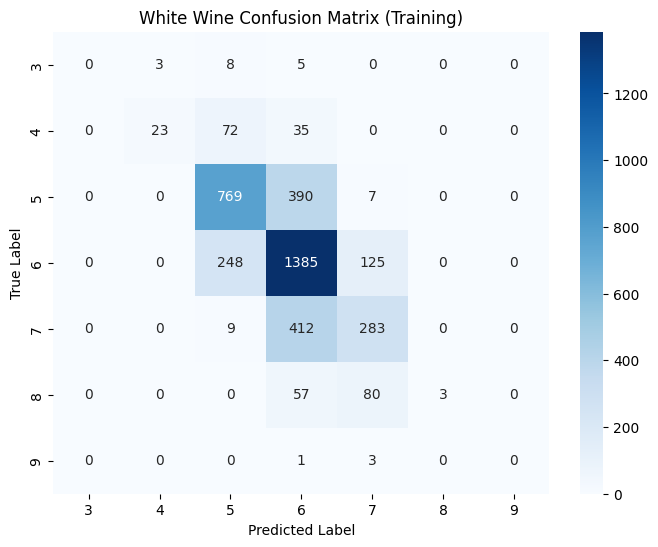

[0.         0.88461538 0.69529837 0.60612691 0.56827309 1.
 0.        ]


In [25]:
white_labels = range(3,10)
white_train_pred = np.rint(svrw_grid.predict(white_X_train))

white_train_class_precision = confusion_matrix_and_class_precision(white_Y_train,
                                                                   white_train_pred,
                                                                   white_labels,
                                                                   "White Wine Confusion Matrix (Training)",
                                                                   "Blues")

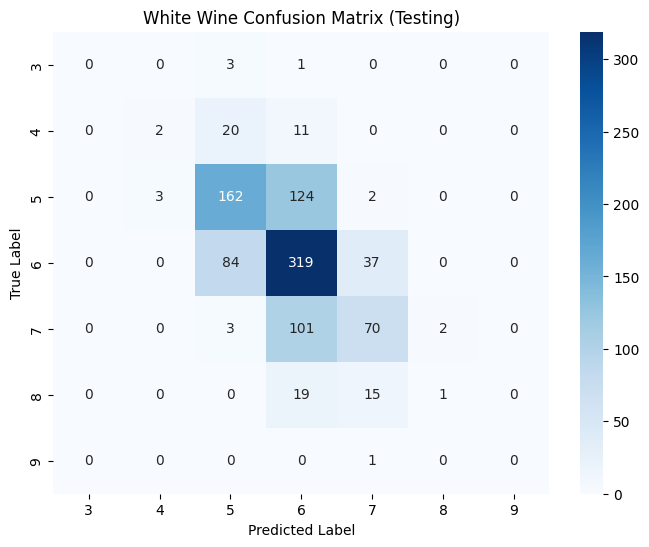

[0.         0.4        0.59558824 0.55478261 0.56       0.33333333
 0.        ]


In [26]:
white_test_pred = np.rint(svrw_grid.predict(white_X_test))

white_test_class_precision = confusion_matrix_and_class_precision(white_Y_test,
                                                                  white_test_pred,
                                                                  white_labels,
                                                                  "White Wine Confusion Matrix (Testing)",
                                                                  "Blues")

In [28]:
print("Accuracy:", accuracy_score(white_Y_test, white_test_pred))

Accuracy: 0.5653061224489796


**Feature Selection**

In [36]:
svrw_fs_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('sfs', SequentialFeatureSelector(LinearSVR(),
                                      n_features_to_select=1,
                                      direction='forward',
                                      scoring='neg_mean_squared_error')),
    ('svm', SVR())
])

svrw_fs_param_grid = {
    'sfs__n_features_to_select': np.arange(3, 11),
    'svm__kernel': ['rbf'],
    'svm__C': [0.01, 0.1, 1.0, 10.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__epsilon': [0.01, 0.05, 0.1]
}

svrw_fs_grid = GridSearchCV(svrw_fs_pipeline, svrw_fs_param_grid, scoring='neg_mean_squared_error', n_jobs=4)
svrw_fs_grid.fit(white_X_train, white_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('sfs',
                                        SequentialFeatureSelector(estimator=LinearSVR(),
                                                                  n_features_to_select=1,
                                                                  scoring='neg_mean_squared_error')),
                                       ('svm', SVR())]),
             n_jobs=4,
             param_grid={'sfs__n_features_to_select': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                         'svm__C': [0.01, 0.1, 1.0, 10.0],
                         'svm__epsilon': [0.01, 0.05, 0.1],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['rbf']},
             scoring='neg_mean_squared_error')

In [38]:
svrw_fs_grid.best_params_

{'sfs__n_features_to_select': np.int64(10),
 'svm__C': 1.0,
 'svm__epsilon': 0.1,
 'svm__gamma': 'auto',
 'svm__kernel': 'rbf'}

Features selected:

In [39]:
white_X_train.columns[svrw_fs_grid.best_estimator_['sfs'].get_support()]

Index(['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides',
       'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH',
       'sulphates', 'alcohol'],
      dtype='object')

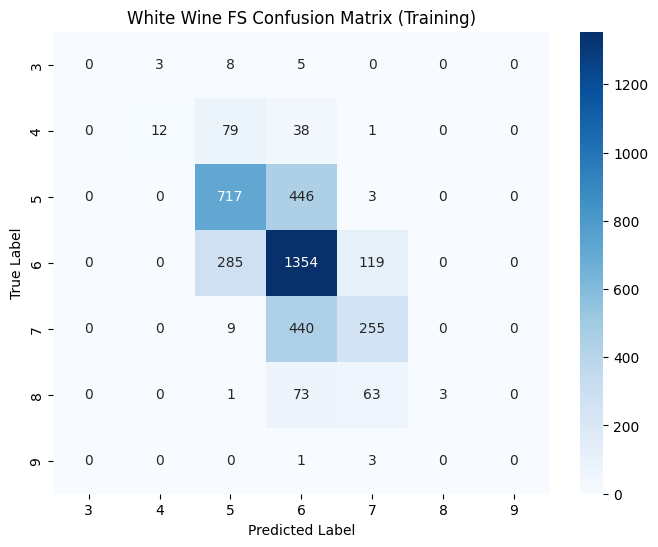

[0.         0.8        0.65241128 0.57445906 0.57432432 1.
 0.        ]


In [42]:
white_sfs_train_pred = np.rint(svrw_fs_grid.predict(white_X_train))

white_sfs_train_class_precision = confusion_matrix_and_class_precision(white_Y_train,
                                                                       white_sfs_train_pred,
                                                                       white_labels,
                                                                       "White Wine FS Confusion Matrix (Training)",
                                                                       "Blues")

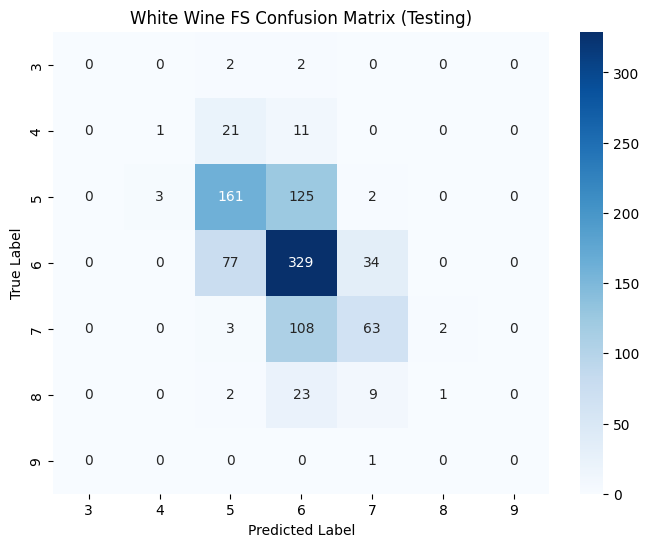

[0.         0.25       0.60526316 0.55016722 0.57798165 0.33333333
 0.        ]


In [43]:
white_sfs_test_pred = np.rint(svrw_fs_grid.predict(white_X_test))

white_sfs_test_class_precision = confusion_matrix_and_class_precision(white_Y_test,
                                                                      white_sfs_test_pred,
                                                                      white_labels,
                                                                      "White Wine FS Confusion Matrix (Testing)",
                                                                      "Blues")

In [44]:
print("Accuracy:", accuracy_score(white_Y_test, white_sfs_test_pred))

Accuracy: 0.5663265306122449


In [45]:
white_class_precision_table = pd.DataFrame(zip(white_train_class_precision, white_test_class_precision,
                                               white_sfs_train_class_precision, white_sfs_test_class_precision),
                                           columns=['Training', 'Testing', 'FS Training', 'FS Testing'],
                                           index=white_labels)

white_class_precision_table.loc['Avg'] = white_class_precision_table.mean()

white_class_precision_table

,Training,Testing,FS Training,FS Testing
3,0.000000,0.000000,0.000000,0.000000
4,0.884615,0.400000,0.800000,0.250000
5,0.695298,0.595588,0.652411,0.605263
6,0.606127,0.554783,0.574459,0.550167
7,0.568273,0.560000,0.574324,0.577982
8,1.000000,0.333333,1.000000,0.333333
9,0.000000,0.000000,0.000000,0.000000
Avg,0.536331,0.349101,0.514456,0.330964
